## Evaluate unsupervised clustering with a VAE 

In [1]:
from typing import Tuple

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T
from matplotlib import pyplot as plt
from vaes.ssvae import SSVAE

ssvae = SSVAE.load_from_checkpoint("../models/vae-normal-categorical-v1.ckpt")

In [2]:
def load_data(data_dir: str = "~/data", **kwargs) -> Tuple[DataLoader, DataLoader]:
    train_loader = DataLoader(
        datasets.MNIST(
            data_dir,
            train=True,
            download=True,
            transform=T.ToTensor(),
        ),
        shuffle=True,
        **kwargs,
    )

    test_loader = DataLoader(
        datasets.MNIST(
            data_dir,
            train=False,
            download=True,
            transform=T.ToTensor(),
        ),
        shuffle=False,
        **kwargs,
    )

    return train_loader, test_loader

train_loader, test_loader = load_data(batch_size=128)

In [3]:
@torch.no_grad()
def embed(model, data_loader):
    ssvae.eval()
    xs, zs, ys = [], [], []
    for x, y in data_loader:
        ys.append(ssvae.py_params(x)[0])
        zs.append(ssvae.pz_params(x)[0])
        xs.append(x)

    return torch.cat(xs, 0), torch.cat(zs, 0), torch.cat(ys, 0)

xs, zs, ys = embed(ssvae, test_loader)
preds = ys.argmax(-1)

## Look at clusters

<BarContainer object of 10 artists>

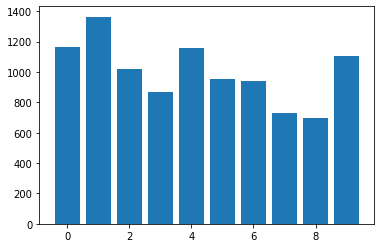

In [4]:
fig, ax = plt.subplots()
uniques, counts = torch.unique(preds, return_counts=True)
ax.bar(uniques.numpy(), counts.numpy())

In [5]:
def plot_samples(xs):
    h, w = 5, 3
    fig, axs = plt.subplots(h, w, figsize=(10, 8))
    for x, ax in zip(xs, axs.flatten()):
        ax.imshow(x.squeeze().numpy())

    return fig

Text(0.5, 0.98, 'Ones')

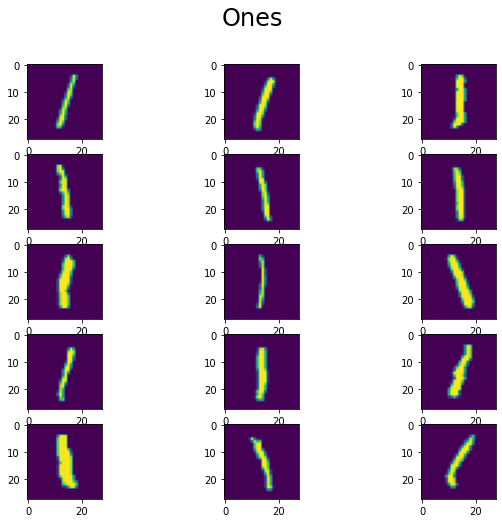

In [6]:
fig = plot_samples(xs[preds.eq(9)])
fig.suptitle("Ones", fontsize=24)

Text(0.5, 0.98, 'Zeros (and sixes)')

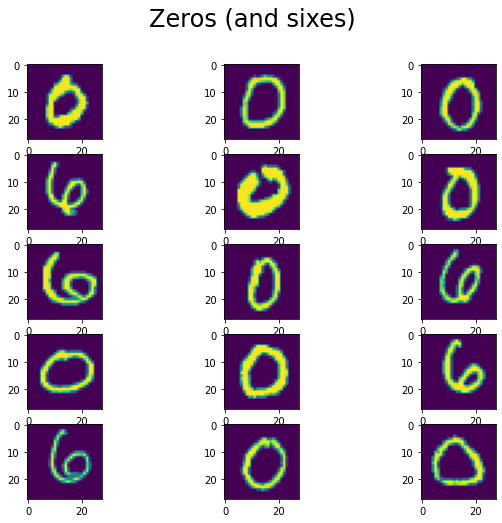

In [7]:
fig = plot_samples(xs[preds.eq(0)])
fig.suptitle("Zeros (and sixes)", fontsize=24)

Text(0.5, 0.98, 'Twos')

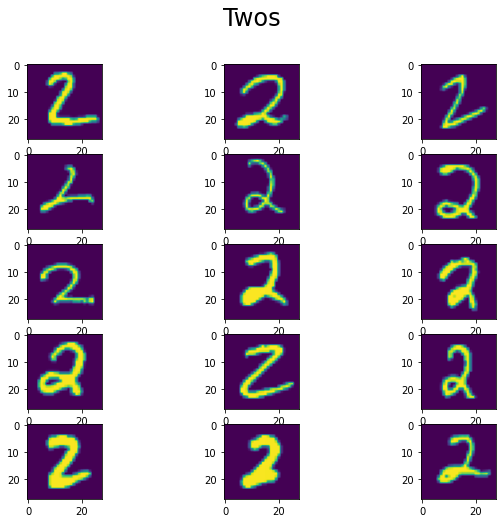

In [8]:
fig = plot_samples(xs[preds.eq(5)])
fig.suptitle("Twos", fontsize=24)

Text(0.5, 0.98, 'Scrambles')

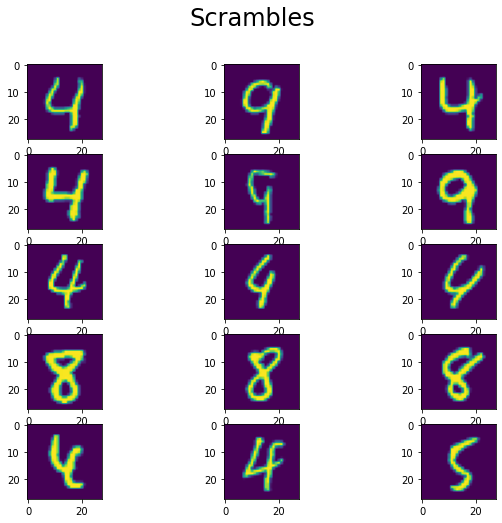

In [9]:
fig = plot_samples(xs[preds.eq(6)])
fig.suptitle("Scrambles", fontsize=24)

## Image reconstruction

Text(0.5, 0.98, 'Image reconstruction')

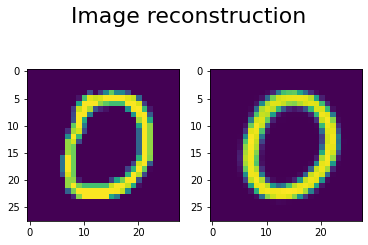

In [10]:
x = xs[10]
x_rec = ssvae.reconstruct(x)
fig, (x_ax, rec_ax) = plt.subplots(1, 2)
x_ax.imshow(x.squeeze().numpy())
rec_ax.imshow(x_rec.squeeze().numpy())
fig.suptitle("Image reconstruction", fontsize=22)

## Conditional sampling

In [48]:

def plot_class_samples(model, y):
    h, w = 5, 5
    samples = model.sample(num_samples=h*w, y=y)[0]
    fig, axs = plt.subplots(5, 5)
    for x, ax in zip(samples, axs.ravel()):        
        ax.imshow(x.squeeze().numpy())


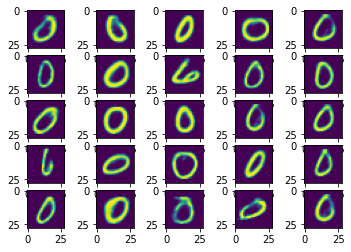

In [49]:
plot_class_samples(ssvae, y=0)

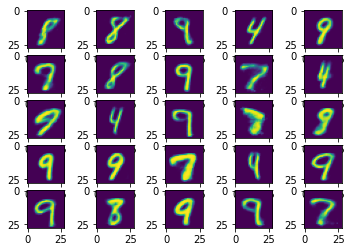

In [50]:
plot_class_samples(ssvae, y=2)

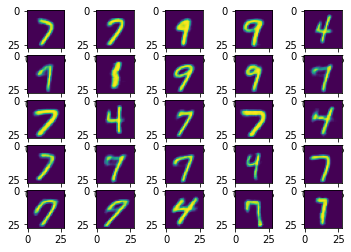

In [51]:
plot_class_samples(ssvae, y=1)

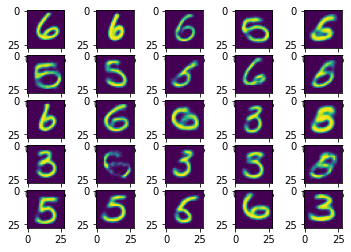

In [53]:
plot_class_samples(ssvae, y=4)

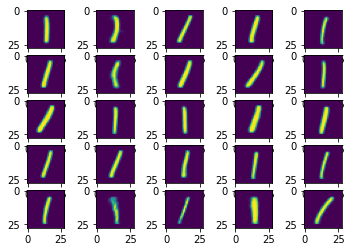

In [57]:
plot_class_samples(ssvae, y=9)